In [ ]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score

In [29]:
basedir = "/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/stop_M1000_988_ct200_2018"
treename = "Events"  # change if your tree is named differently

arr = uproot.concatenate(f"{basedir}/**/*.root:{treename}",
                         ["SDVSecVtx_matchedLLPnDau_bydau",
                          "vtx_PART_353best_val_epoch",
                          "vtx_PART_338_epoch_6",
                          "vtx_PART_338_epoch_7"], library="ak")

# Example use:
branchA = arr["SDVSecVtx_matchedLLPnDau_bydau"]
branchB = arr["vtx_PART_353best_val_epoch"]

In [30]:
A_flat = ak.flatten(arr["SDVSecVtx_matchedLLPnDau_bydau"])
B_flat = ak.flatten(arr["vtx_PART_353best_val_epoch"])

A_flat = ak.values_astype(A_flat > 1, 'int')
prec, recall, _ = precision_recall_curve(A_flat, B_flat)

# import matplotlib.pyplot as plt
# plt.plot(recall, prec)
# plt.xlabel('TPR')
# plt.ylabel('PPV')

auc_precision_recall = auc(recall, prec)
print('PR-AUC: ', auc_precision_recall)
print('ROC-AUC: ', roc_auc_score(A_flat, B_flat))

PR-AUC:  0.871815731566361
ROC-AUC:  0.9665761022371898


In [37]:
A_flat = ak.flatten(arr["SDVSecVtx_matchedLLPnDau_bydau"])
B_flat = ak.flatten(arr["vtx_PART_338_epoch_6"])

A_flat = ak.values_astype(A_flat > 1, 'int')
prec, recall, _ = precision_recall_curve(A_flat, B_flat)

p1 = prec
r1 = recall

# import matplotlib.pyplot as plt
# plt.plot(recall, prec)
# plt.xlabel('TPR')
# plt.ylabel('PPV')

auc_precision_recall = auc(recall, prec)
print('PR-AUC: ', auc_precision_recall)
print('ROC-AUC: ', roc_auc_score(A_flat, B_flat))

PR-AUC:  0.7908536318775311
ROC-AUC:  0.9419097537139612


In [38]:
A_flat = ak.flatten(arr["SDVSecVtx_matchedLLPnDau_bydau"])
B_flat = ak.flatten(arr["vtx_PART_338_epoch_7"])

A_flat = ak.values_astype(A_flat > 1, 'int')
prec, recall, _ = precision_recall_curve(A_flat, B_flat)

p2 = prec
r2 = recall

# import matplotlib.pyplot as plt
# plt.plot(recall, prec)
# plt.xlabel('TPR')
# plt.ylabel('PPV')

auc_precision_recall = auc(recall, prec)
print('PR-AUC: ', auc_precision_recall)
print('ROC-AUC: ', roc_auc_score(A_flat, B_flat))

PR-AUC:  0.8669749079960714
ROC-AUC:  0.9649352056992371


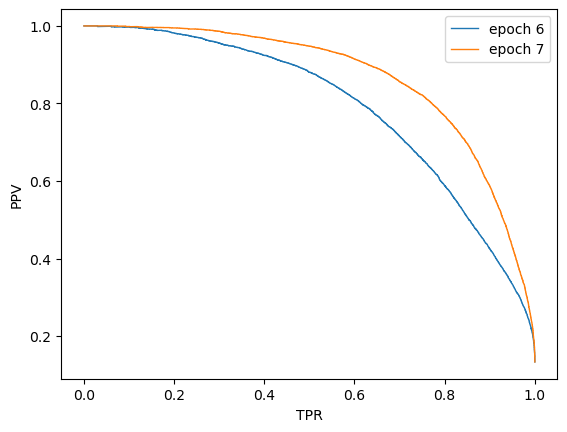

In [40]:
plt.plot(r1, p1, lw=1, label='epoch 6')
plt.plot(r2, p2, lw=1, label='epoch 7')
plt.xlabel('TPR')
plt.ylabel('PPV')
plt.legend()
# plt.savefig('PR_curve.png')

(0.9, 1.02)

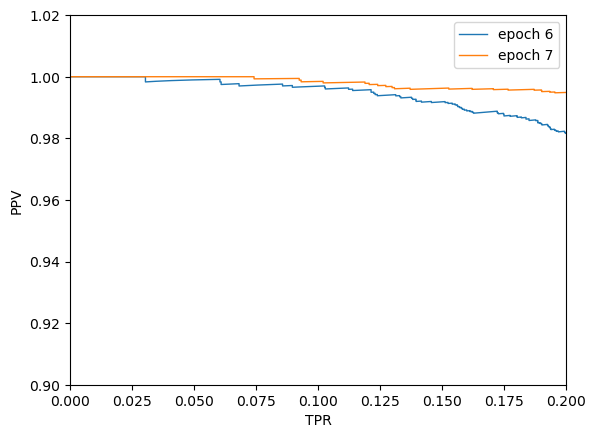

In [44]:
plt.plot(r1, p1, lw=1, label='epoch 6')
plt.plot(r2, p2, lw=1, label='epoch 7')
plt.xlabel('TPR')
plt.ylabel('PPV')
plt.legend()
plt.xlim(0,0.2)
plt.ylim(0.90, 1.02)
# plt.savefig('PR_curve.png')

In [47]:
basedir = "/scratch-cbe/users/alikaan.gueven/ML_KAAN/run2/stop_M1000_988_ct200_2018"
treename = "Events"  # change if your tree is named differently

iterator = uproot.iterate(f"{basedir}/**/*.root:{treename}",
                         ["SDVSecVtx_matchedLLPnDau_bydau",
                          "vtx_PART_353best_val_epoch",
                          "vtx_PART_338_epoch_6",
                          "vtx_PART_338_epoch_7"], library="ak")

In [53]:
min_tokens = 2
for it in iterator:
    cnt = ak.num(it["SDVSecVtx_matchedLLPnDau_bydau"], axis=1)
    print(cnt)
    print(cnt>= min_tokens)
    break

[6, 10, 1, 4, 3, 4, 1, 3, 2, 5, 0, 2, ..., 8, 4, 4, 5, 6, 5, 5, 4, 7, 11, 4, 5]
[True, True, False, True, True, True, ..., True, True, True, True, True, True]


In [114]:
def superbatch_iterator(files, keys, superbatch_size=100, drop_last=True):
    """
    Retrieves same number of entries in each iteration for stable training.

    WARNING: Set drop_last=False in prediction mode,
             otherwise last batch will be dropped!!

    Parameters
    ----------
    files: file paths as in uproot.iterator
    keys: TBranch names in list
    superbatch_size: batch_size * multiplet 
    """
    arrays = []
    num_entries = 0
    iterator = uproot.iterate(files, keys, step_size=superbatch_size, library="ak",
                              ) 

    for it in iterator:
        it_length = it.type.length

        if num_entries + it_length < superbatch_size:
            # Batch is missing some entries, get more entries
            arrays.append(it)
            num_entries += it_length
        else:
            # If batch is ready or more than ready, handle it
            remaining = superbatch_size - num_entries

            if remaining > 0:
                arrays.append(it[:remaining])
                yield ak.concatenate(arrays)  # next iteration starts directly after this line.
                arrays = [it[remaining:]]
                num_entries = it_length - remaining
            elif remaining == 0:
                yield ak.concatenate(arrays)  # next iteration starts directly after this line.
                arrays = []
                num_entries = 0
            else:
                raise RuntimeError("This basically should not happen.")


    # Sometimes last batch has only 1 element which is not enough for BatchNorm layers.
    # They fail the training quite unexpectedly, after many epochs.
    # Handle the last batch
    if arrays and not drop_last:
        yield ak.concatenate(arrays)
    else:
        pass # Last batch is dropped


step_size=3000
x = superbatch_iterator(f"{basedir}/**/*.root:{treename}",
                         ["SDVSecVtx_matchedLLPnDau_bydau",
                          "vtx_PART_353best_val_epoch",
                          "vtx_PART_338_epoch_6",
                          "vtx_PART_338_epoch_7"],
                          superbatch_size=step_size,
                          drop_last=False)




for i, it in enumerate(x):
    if len(it) != step_size: print(i, len(it))

12 983


In [103]:
x = uproot.iterate(f"{basedir}/**/*.root:{treename}",
                         ["SDVSecVtx_matchedLLPnDau_bydau",
                          "vtx_PART_353best_val_epoch",
                          "vtx_PART_338_epoch_6",
                          "vtx_PART_338_epoch_7"],
                    step_size=100,
                    library="ak") 

for i, it in enumerate(x):
    if len(it) != 100: print(i, len(it))

18 12
36 52
56 1
75 51
94 10
113 8
132 11
151 63
170 20
189 51
208 76
227 72
246 10
265 37
284 78
304 41
323 87
342 38
361 25
381 40
